# LSTM

## load data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

def load_and_preprocess(train_path, test_path):
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    # 删除包含 NaN 的行
    train_df = train_df.dropna()
    test_df = test_df.dropna()

    # 将 'time' 列转换为 datetime 格式并设置为索引
    train_df['time'] = pd.to_datetime(train_df['time'], format='%Y-%m-%d %H:%M:%S.%f')
    train_df.set_index('time', inplace=True)

    test_df['time'] = pd.to_datetime(test_df['time'], format='%Y-%m-%d %H:%M:%S.%f')
    test_df.set_index('time', inplace=True)

    # 提取特征和标签
    X_train = train_df.drop(columns=['attack'])
    y_train = train_df['attack']

    X_test = test_df.drop(columns=['attack'])
    y_test = test_df['attack']

    # 标准化特征
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_and_preprocess('../data/merged_table_attack_1_withtag_processed.csv', '../data/merged_table_attack_2_withtag_processed.csv')
# X_train, y_train, X_test, y_test = load_and_preprocess('../data/attack1_without_EMS.csv', '../data/attack2_without_EMS.csv')

## difine model

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.long)

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train.shape[1]
hidden_size = 64
num_layers = 2
num_classes = 2
model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes)

## train

In [3]:
import torch.optim as optim

# 设定设备
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 50
batch_size = 64

def train_model(model, X_train, y_train, num_epochs, batch_size):
    model.train()
    for epoch in range(num_epochs):
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i+batch_size].unsqueeze(1).to(device)
            y_batch = y_train[i:i+batch_size].to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

train_model(model, X_train, y_train, num_epochs, batch_size)


Epoch [10/50], Loss: 0.0012
Epoch [20/50], Loss: 0.0000
Epoch [30/50], Loss: 0.0005
Epoch [40/50], Loss: 0.0006
Epoch [50/50], Loss: 0.0001


## evaluate

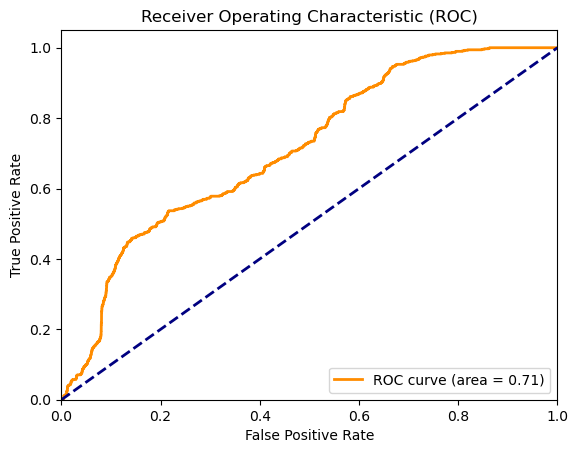

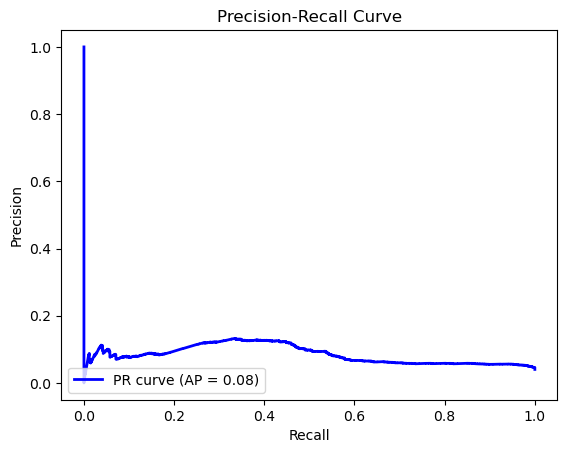

LSTM Accuracy: 0.9574833965844403
LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     16186
           1       0.00      0.00      0.00       678

    accuracy                           0.96     16864
   macro avg       0.48      0.50      0.49     16864
weighted avg       0.92      0.96      0.94     16864



In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score,accuracy_score,classification_report

# 评估模型并绘制ROC和AUC曲线以及PR曲线
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        X_test = X_test.unsqueeze(1).to(device)  # Ensure the input shape is (batch_size, 1, input_size)
        y_test = y_test.to(device)

        outputs = model(X_test)
        _, predicted = torch.max(outputs.data, 1)

        accuracy = accuracy_score(y_test.cpu(), predicted.cpu())
        report = classification_report(y_test.cpu(), predicted.cpu())

        # 计算ROC和AUC
        y_prob = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        fpr, tpr, roc_thresholds = roc_curve(y_test.cpu(), y_prob)
        roc_auc = auc(fpr, tpr)

        # 绘制ROC曲线
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc="lower right")
        plt.show()

        # 计算PR曲线和AP
        precision, recall, pr_thresholds = precision_recall_curve(y_test.cpu(), y_prob)
        average_precision = average_precision_score(y_test.cpu(), y_prob)

        # 绘制PR曲线
        plt.figure()
        plt.plot(recall, precision, color='b', lw=2, label=f'PR curve (AP = {average_precision:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower left")
        plt.show()

        print(f"LSTM Accuracy: {accuracy}")
        print("LSTM Classification Report:")
        print(report)

evaluate_model(model, X_test, y_test)
